In [1]:
import numpy as np

import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torchmetrics import AUROC
from torch_geometric import seed_everything
from torch_geometric.graphgym.models import AtomEncoder

from models.GCN import GCNnet
from data import Tox21Processor

In [2]:
np.random.seed(42)
seed_everything(42)

In [3]:
class LitGNN(pl.LightningModule):
    
    def __init__(self, model, in_channels, current_task, lr, batch_size):
        super().__init__()
        self.model = model
        self.in_channels = in_channels
        self.current_task = current_task
        self.lr = lr
        self.batch_size = batch_size
        self.atom_encoder = AtomEncoder(in_channels)
        self.criterion = nn.BCELoss()
        self.save_hyperparameters(ignore=['model'])

    def forward(self, data):
        return self.model(data)

    def get_loss(self, batch):
        self.atom_encoder(batch)
        output = self.model(batch)
        loss = self.criterion(output, batch.y[:, self.current_task].unsqueeze(1))
        return output, loss

    def training_step(self, batch, batch_idx):
        output, loss = self.get_loss(batch)
        self.log('train_loss', loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        output, loss = self.get_loss(batch)
        auc = AUROC(task="binary")(output, batch.y[:, self.current_task].unsqueeze(1))
        self.log_dict({'val_loss': loss, 'val_auc': auc}, batch_size=self.batch_size)

        return auc

    def test_step(self, batch, batch_idx):
        output, loss = self.get_loss(batch)
        auc = AUROC(task="binary")(output, batch.y[:, self.current_task].unsqueeze(1))
        self.log_dict({'test_loss': loss, 'test_auc': auc}, batch_size=self.batch_size)
        return auc

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [4]:
DATA_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23fall/231007_fgcl/tox21'
tox21 = Tox21Processor(DATA_PATH)
tox21.atom_filter()

In [5]:
in_channels = 64
hidden_channels = 64
num_layers = 2
batch_norm = True
pooling_method = 'global_mean_pool'
task_epochs = 100
lr = 1e-4
batch_size = 64

In [6]:
# wandb_logger = WandbLogger(project='pl_gcn_test')
model = GCNnet(in_channels, hidden_channels, num_layers, batch_norm, pooling_method)
model_states = {}

In [7]:
task_ids = np.arange(12)
np.random.shuffle(task_ids)

In [8]:
task_ids

array([10,  9,  0,  8,  5,  2,  1, 11,  4,  7,  3,  6])

In [9]:
MODEL_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23fall/231007_fgcl/test_1107'

In [10]:
for i, task_id in enumerate(task_ids):
    train_loader, val_loader, test_loader = tox21.generate_dataloaders(task_id=task_id)
    continual_model = LitGNN(model, in_channels, task_id, lr, batch_size)
    if i > 0:
        prev_task_id = task_ids[i - 1]
        continual_model.load_state_dict(model_states[prev_task_id])

    early_stop_callback = EarlyStopping(monitor='val_auc', min_delta=0.00, patience=20, verbose=False, mode='max')
    trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()], default_root_dir=MODEL_PATH)
    trainer.fit(continual_model, train_loader, val_loader)
    model_states[task_id] = continual_model.state_dict()
    trainer.test(continual_model, test_loader)

/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/cz357/.conda/envs/pyg/lib/python3.11/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to 

┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441
: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Output()

/home/cz357/.conda/envs/pyg/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No 
positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive 
score
  warnings.warn(*args, **kwargs)  # noqa: B028

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7841887474060059     │
│         test_loss         │    0.4813186228275299     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7650259137153625     │
│         test_loss         │    0.4423929750919342     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6434184312820435     │
│         test_loss         │    0.11960873752832413    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6628603935241699     │
│         test_loss         │    0.22566184401512146    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

OSError: [Errno 122] Disk quota exceeded

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
metrics_path = '/gpfs/gibbs/pi/gerstein/cz357/23fall/231007_fgcl/test_1107/lightning_logs/'

In [ ]:
task_dfs = []
accumulated_epochs = 0
for i, task_id in enumerate(task_ids):
    task_dfs.append(pd.read_csv(metrics_path+'version_'+str(task_id)+'/metrics.csv'))
    task_dfs[i]['epoch'] += accumulated_epochs
    accumulated_epochs = (task_dfs[i]['epoch'].max() - 1)

In [ ]:
sns.set_palette("Set3")
colors = sns.color_palette()[:12]

In [ ]:
plt.figure(figsize=(12, 6))
for i, df in enumerate(task_dfs):
    plot_df = task_dfs[i][['epoch', 'val_loss']].dropna()
    plt.plot(plot_df['epoch'], plot_df['val_loss'], label=f'task_{i+1}', color=colors[i])
plt.legend(loc='upper left')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

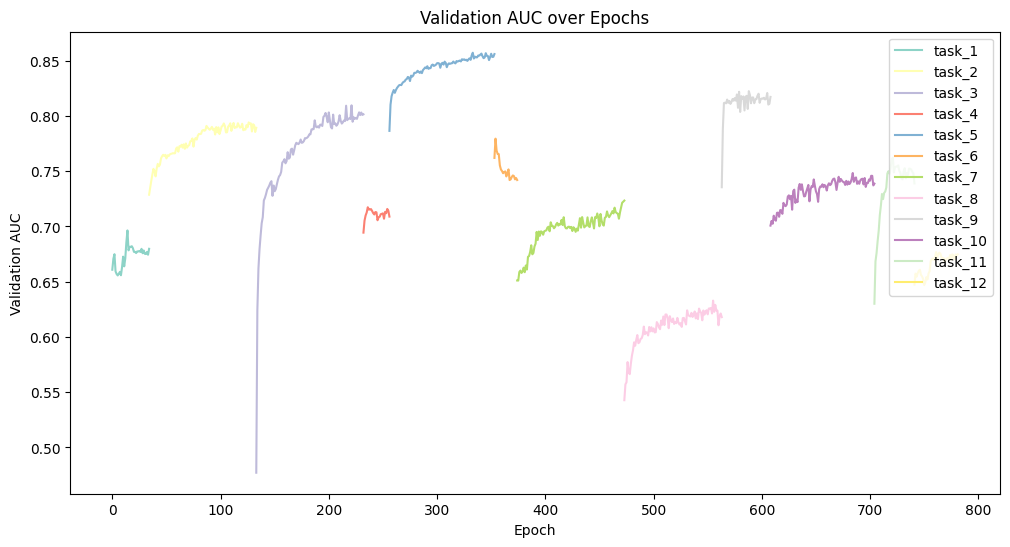

In [21]:
plt.figure(figsize=(12, 6))
for i, df in enumerate(task_dfs):
    plot_df = task_dfs[i][['epoch', 'val_auc']].dropna()
    plt.plot(plot_df['epoch'], plot_df['val_auc'], label=f'task_{i+1}', color=colors[i])
plt.legend(loc='upper right')
plt.title('Validation AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.show()

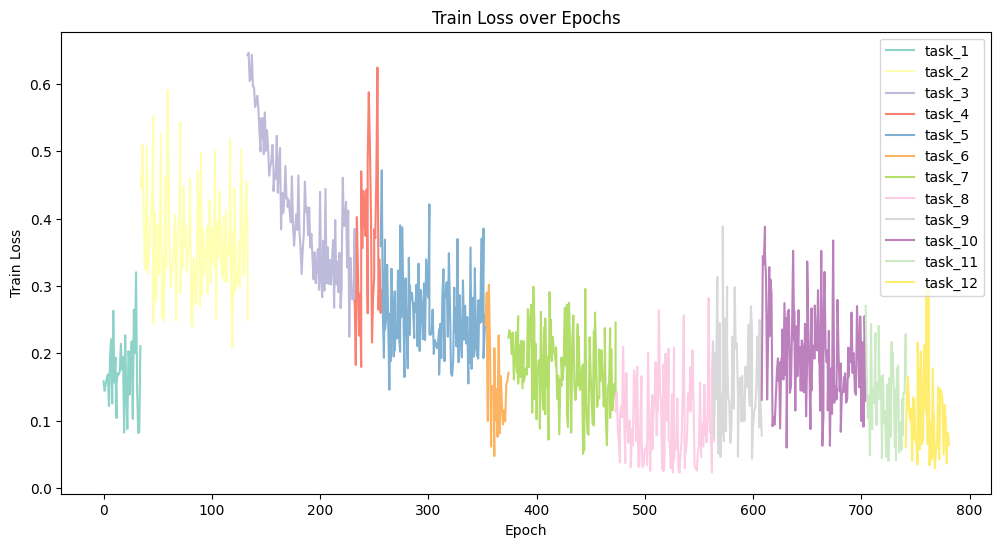

In [22]:
plt.figure(figsize=(12, 6))
for i, df in enumerate(task_dfs):
    plot_df = task_dfs[i][['epoch', 'train_loss']].dropna()
    plt.plot(plot_df['epoch'], plot_df['train_loss'], label=f'task_{i+1}', color=colors[i])
plt.legend(loc='upper right')
plt.title('Train Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

In [23]:
task_ids

array([10,  9,  0,  8,  5,  2,  1, 11,  4,  7,  3,  6])

In [26]:
train_loader, val_loader, test_loader = tox21.generate_dataloaders(10)
test_model = LitGNN(model, in_channels, 10, lr, batch_size)
trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
test_model.load_state_dict(model_states[3])
trainer.test(test_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7714632153511047     │
│         test_loss         │    0.4591372609138489     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4591372609138489, 'test_auc': 0.7714632153511047}]

In [40]:
test_model.load_state_dict(model_states[3])
trainer.test(test_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7714632749557495     │
│         test_loss         │    0.4591372609138489     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4591372609138489, 'test_auc': 0.7714632749557495}]

In [21]:
test_model.load_state_dict(model_states[4])
trainer.test(test_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:00 • 0:00:00 30.04it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7206041216850281     │
│         test_loss         │    0.18922464549541473    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.18922464549541473, 'test_auc': 0.7206041216850281}]

In [22]:
test_model.load_state_dict(model_states[2])
trainer.test(test_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:00 • 0:00:00 30.48it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.5166947841644287     │
│         test_loss         │    0.3143273890018463     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3143273890018463, 'test_auc': 0.5166947841644287}]

In [23]:
test_model.load_state_dict(model_states[5])
trainer.test(test_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:00 • 0:00:00 29.95it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6403483152389526     │
│         test_loss         │     0.211542546749115     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.211542546749115, 'test_auc': 0.6403483152389526}]

In [24]:
test_model.load_state_dict(model_states[1])
trainer.test(test_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:00 • 0:00:00 30.50it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6665565967559814     │
│         test_loss         │    0.19279108941555023    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19279108941555023, 'test_auc': 0.6665565967559814}]

In [26]:
test_model.load_state_dict(model_states[0])
trainer.test(test_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:00 • 0:00:00 29.86it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7066901922225952     │
│         test_loss         │    0.2810429334640503     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2810429334640503, 'test_auc': 0.7066901922225952}]

In [7]:
for task_id in range(0, 3):
    train_loader, val_loader, test_loader = tox21.generate_dataloaders(task_id=task_id)
    continual_model = LitGNN(model, in_channels, task_id, lr, batch_size)
    
    if task_id > 0 and model_states != {}:
        continual_model.load_state_dict(model_states[task_id-1])
    
    # trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()], logger=wandb_logger)
    trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()])
    trainer.fit(continual_model, train_loader, val_loader)
    model_states[task_id] = continual_model.state_dict()
    trainer.test(continual_model, test_loader)

/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cz357/.conda/envs/pyg_env/lib/python3.11/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of 

┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py
:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py
:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of
the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No 
positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive 
score
  warnings.warn(*args, **kwargs)  # noqa: B028

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/cz357/.conda/envs/pyg_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │     0.740557849407196     │
│         test_loss         │    0.27522921562194824    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6741289496421814     │
│         test_loss         │     0.231984943151474     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model        │ GCNnet      │  8.6 K │
│ 1 │ atom_encoder │ AtomEncoder │ 11.1 K │
│ 2 │ criterion    │ BCELoss     │      0 │
└───┴──────────────┴─────────────┴────────┘

Trainable params: 19.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.6922842860221863     │
│         test_loss         │    0.39563751220703125    │
└───────────────────────────┴───────────────────────────┘

In [18]:
len(model_states)

3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv
import torch.distributions as dist

# Define the Graph VAE model
class GraphVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphVAE, self).__init__()
        self.encoder = nn.Sequential(
            GCNConv(input_dim, hidden_dim),
            nn.ReLU(),
            GCNConv(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(hidden_dim, latent_dim)
        self.z_log_var = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            GCNConv(latent_dim, hidden_dim),
            nn.ReLU(),
            GCNConv(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def forward(self, x, edge_index):
        hidden = self.encoder(x, edge_index)
        mean = self.z_mean(hidden)
        log_var = self.z_log_var(hidden)
        z = self.reparameterize(mean, log_var)
        recon_x = self.decoder(z, edge_index)
        return recon_x, mean, log_var

# Define the loss function
def loss_function(recon_x, x, mean, log_var):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_divergence

# Load TOX21 dataset and create DataLoader
dataset = TUDataset(root='./data', name='TOX21')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the Graph VAE model
input_dim = dataset.num_features
hidden_dim = 64
latent_dim = 16
model = GraphVAE(input_dim, hidden_dim, latent_dim)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    for data in loader:
        optimizer.zero_grad()
        recon_x, mean, log_var = model(data.x, data.edge_index)
        loss = loss_function(recon_x, data.x, mean, log_var)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/100], Loss: {loss.item()}')

# Generate graphs from the learned model
with torch.no_grad():
    z = torch.randn(1, latent_dim)
    generated_graph = model.decoder(z, edge_index)


In [ ]:
for task_id in range(0, 3):
    train_loader, val_loader, test_loader = tox21.generate_dataloaders(task_id=task_id)
    trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()], logger=wandb_logger)
    trainer.fit(continual_model, train_loader, val_loader)
    trainer.test(continual_model, test_loader)

In [ ]:
CKPT_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23fall/fgcl_ckpts/gcl_ckpts/'

In [15]:
continual_model = LitGNN(model=model, in_channels=in_channels, current_task=current_task, task_epochs=task_epochs, lr=lr)
early_stop_callback = EarlyStopping(monitor='val_auc', min_delta=0.00, patience=10, verbose=False, mode='max')
trainer = pl.Trainer(max_epochs=task_epochs, callbacks=[early_stop_callback, RichProgressBar()], logger=wandb_logger)
trainer.fit(continual_model, train_loader, val_loader)

Epoch 49/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63/63 0:00:00 • 0:00:00 73.37it/s v_num: j5ic

`Trainer.fit` stopped: `max_epochs=50` reached.


In [17]:
trainer.test(continual_model, test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22/22 0:00:00 • 0:00:00 80.20it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7183268666267395     │
│         test_loss         │     0.297260582447052     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.297260582447052, 'test_auc': 0.7183268666267395}]

In [ ]:
DATA_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23fall/231007_fgcl/tox21'
tox21 = Tox21Processor(DATA_PATH)
tox21.atom_filter()

In [ ]:
in_channels = 64
task_epochs = 50
lr = 0.0001

In [ ]:
# Test the model on the last task
test_results = trainer.test(model, test_dataloaders=test_loader)

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader

class ContinualGraphLearner(pl.LightningModule):
    def __init__(self, model, lr=0.0001, loss_fn=nn.BCELoss(), num_epochs_per_task=50):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        self.num_epochs_per_task = num_epochs_per_task
        self.current_task = 0
        self.optimizers = []
        

    def forward(self, data):
        return self.model(data)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=lr=self.lr)

    def training_step(self, batch, batch_idx):
        data, task_id = batch
        self.current_task = task_id

        output = self(data)
        loss = self.criterion(output, data.y)

        self.log('task_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def train_dataloader(self):
        # Return the DataLoader for the current task
        # You need to implement a way to switch between different tasks' data.
        # For example, you can create a list of DataLoaders for each task and
        # return the DataLoader for the current task based on self.current_task.
        return your_data_loader

    def on_epoch_end(self):
        # After a certain number of epochs, switch to the next task
        if self.current_epoch % num_epochs_per_task == 0:
            self.current_task += 1
            if self.current_task < num_tasks:
                self.optimizers = []  # Clear optimizers to create a new one
                self.trainer.lr_schedulers = []  # Clear learning rate schedulers
                # Update data loader for the new task and call self.train_dataloader() again

def train_continual_gcn(model, num_epochs_per_task, num_tasks, learning_rate):
    # Initialize the ContinualGCN LightningModule
    continual_gcn = ContinualGCN(model, criterion, learning_rate)
    trainer = pl.Trainer(max_epochs=num_epochs_per_task * num_tasks)
    trainer.fit(continual_gcn)

# Usage
train_continual_gcn(your_gcn_model, num_epochs_per_task, num_tasks, learning_rate)


In [2]:
in_channels = 64
atom_encoder = AtomEncoder(in_channels)

In [3]:
DATA_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23fall/231007_fgcl/tox21'

In [4]:
tox21 = Tox21Processor(DATA_PATH)

In [5]:
tox21.atom_filter()

In [6]:
train_loader, val_loader, test_loader = tox21.generate_dataloaders(task_id=2)

In [15]:
a = next(iter(train_loader))

In [7]:
def train(model, optimizer, criterion, task_id):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        atom_encoder(data)
        output = model(data)
        loss = criterion(output, data.y[:, task_id].unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss = total_loss / len(train_loader)
    return loss

In [8]:
def evaluate(model, loader, criterion, task_id):
    model.eval()
    true_labels = []
    predicted_probs = []
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            atom_encoder(data)
            output = model(data)
            loss = criterion(output, data.y[:, task_id].unsqueeze(1))
            total_loss += loss.item()

            true_labels.extend(data.y.cpu().numpy()[:, task_id])
            predicted_probs.extend(output.cpu().numpy())

    loss = total_loss / len(loader)
    auc = roc_auc_score(true_labels, predicted_probs)
    return loss, auc

In [9]:
num_epochs = 50
learning_rate = 0.0001
model = GCNnet(in_channels=64, hidden_channels=64, batch_norm=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [10]:
best_val_auc = final_test_auc = 0
for epoch in range(num_epochs):
    train_loss = train(model, optimizer, criterion, 2)
    val_loss, val_auc = evaluate(model, val_loader, criterion, 2)
    test_loss, test_auc = evaluate(model, test_loader, criterion, 2)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
print(f"Validation AUC: {best_val_auc:.4f}")
print(f"Test AUC: {final_test_auc:.4f}")

Validation AUC: 0.8682
Test AUC: 0.8316
